<a href="https://colab.research.google.com/github/Rafazand/MachineL/blob/main/traindataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets and DataLoaders

In [5]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names


root = "/content/drive/MyDrive/dataset"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

80
5
141
{'Agaricus bisporus': 0, 'Agaricus subrufescens': 1, 'Amanita bisporigera': 2, 'Amanita muscaria': 3, 'Amanita ocreata': 4, 'Amanita phalloides': 5, 'Amanita smithiana': 6, 'Amanita verna': 7, 'Amanita virosa': 8, 'Auricularia auricula-judae': 9, 'Boletus edulis': 10, 'Cantharellus cibarius': 11, 'Clitocybe dealbata': 12, 'Conocybe filaris': 13, 'Coprinus comatus': 14, 'Cordyceps sinensis': 15, 'Cortinarius rubellus': 16, 'Entoloma sinuatum': 17, 'Flammulina velutipes': 18, 'Galerina marginata': 19, 'Ganoderma lucidum': 20, 'Grifola frondosa': 21, 'Gyromitra esculenta': 22, 'Hericium erinaceus': 23, 'Hydnum repandum': 24, 'Hypholoma fasciculare': 25, 'Inocybe erubescens': 26, 'Lentinula edodes': 27, 'Lepiota brunneoincarnata': 28, 'Macrolepiota procera': 29, 'Morchella esculenta': 30, 'Omphalotus olearius': 31, 'Paxillus involutus': 32, 'Pholiota nameko': 33, 'Pleurotus citrinopileatus': 34, 'Pleurotus eryngii': 35, 'Pleurotus ostreatus': 36, 'Psilocybe semilanceata': 37, 'Rho

Data Visualization

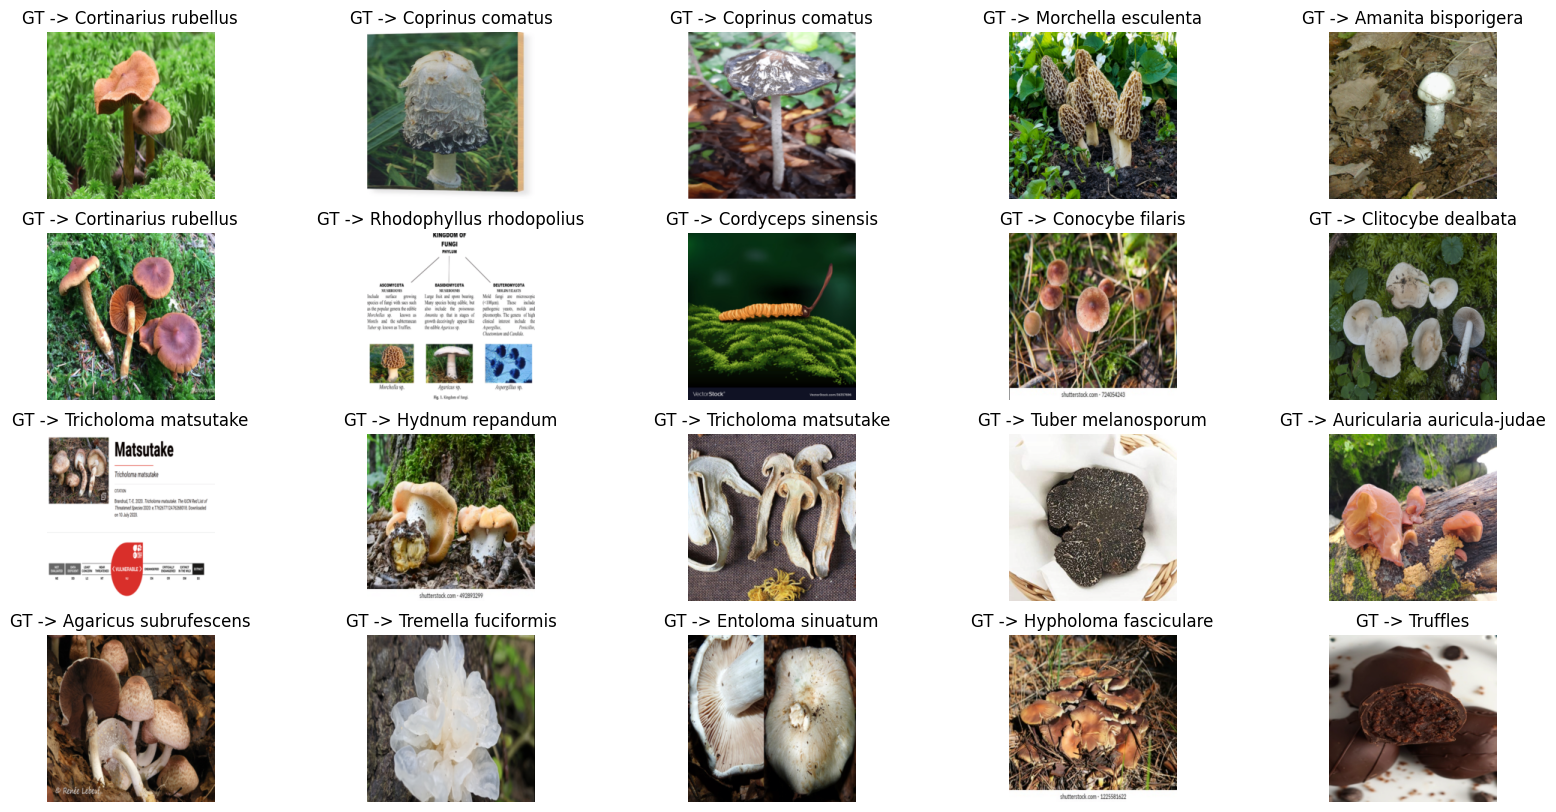

In [6]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

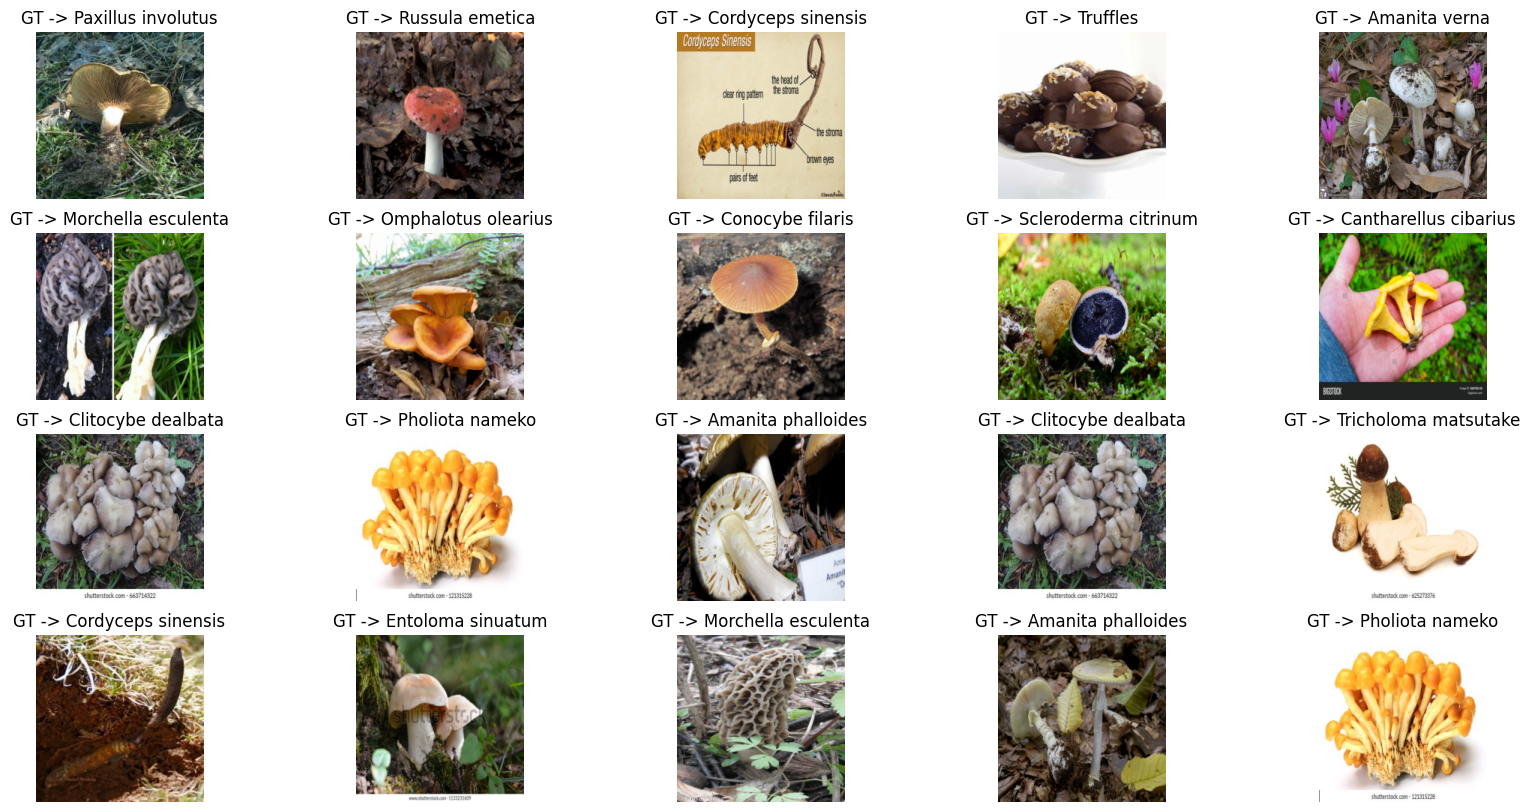

In [7]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

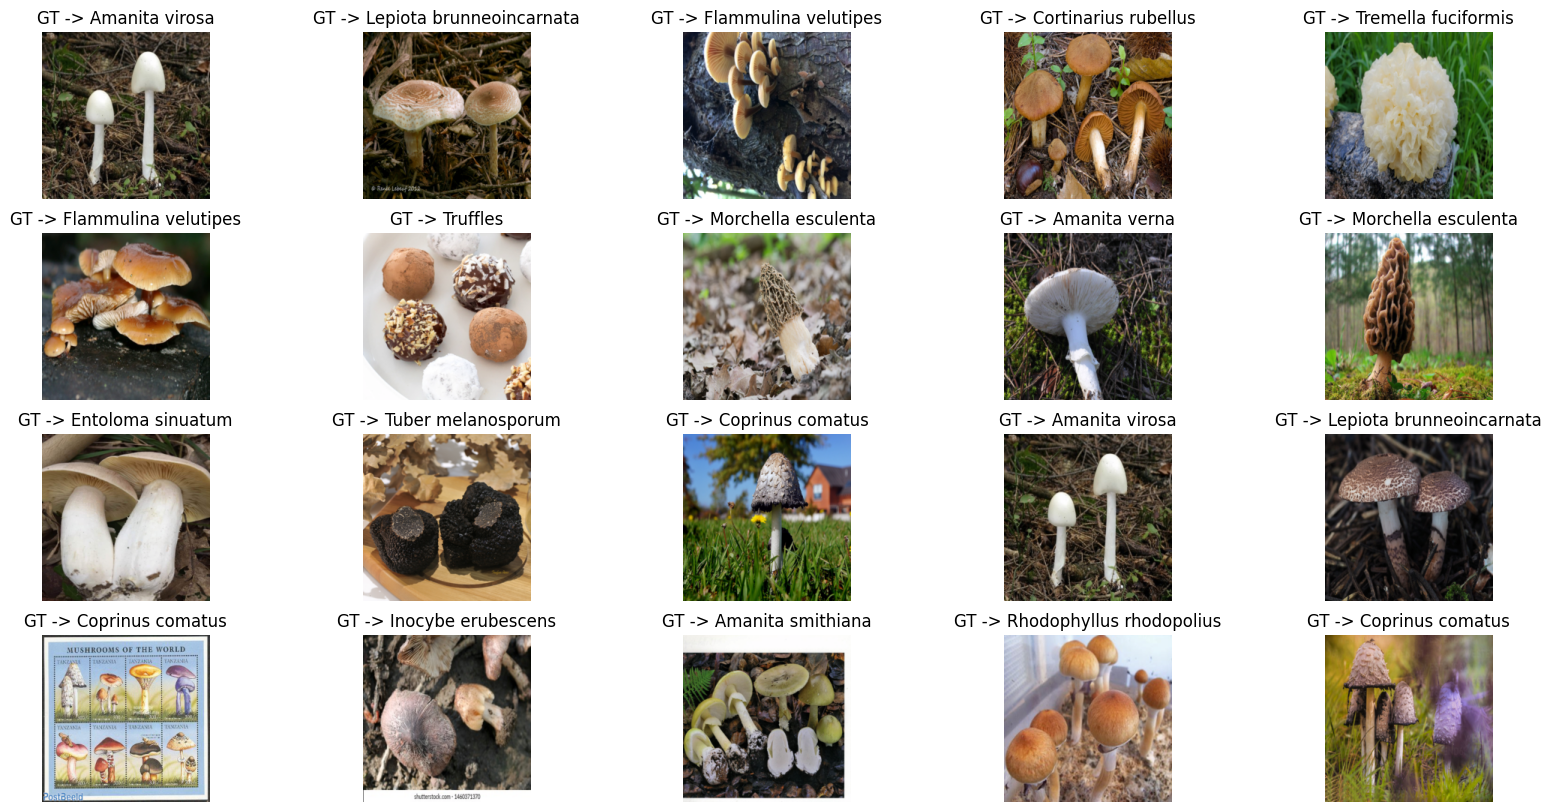

In [4]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

Data Analysis

<ipython-input-8-ff1e220b703f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


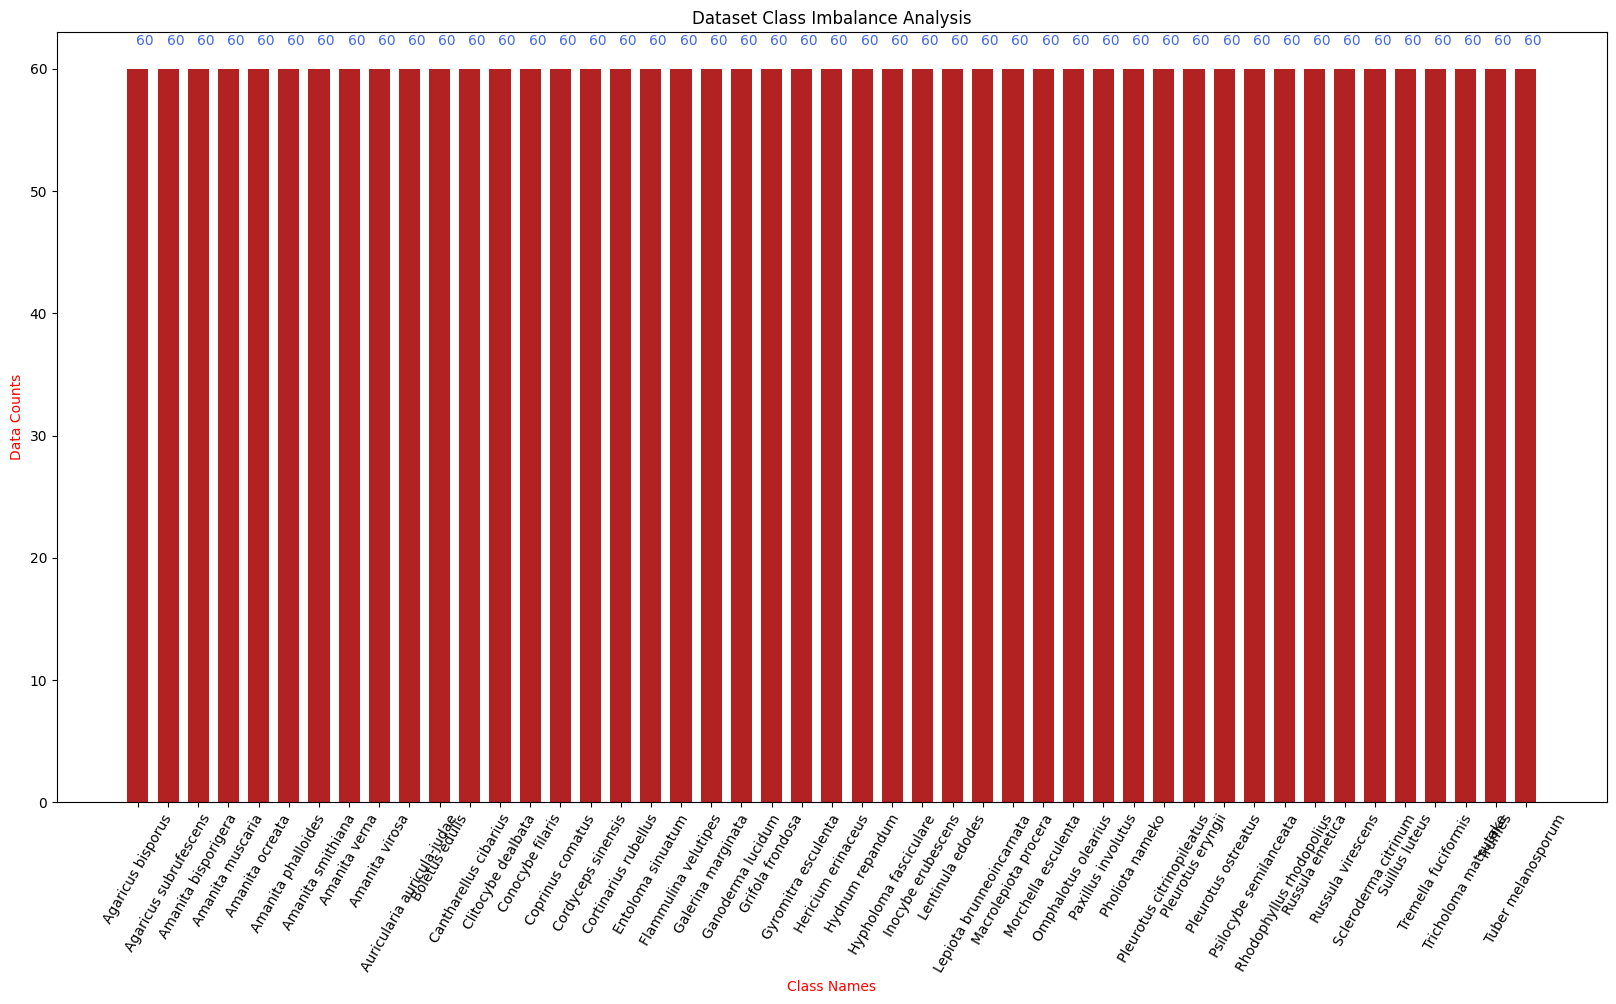

In [8]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

Train and Validation

In [10]:
import timm
from tqdm import tqdm
import torch
import os

# Create model
m = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes))

# Function to set up training with appropriate device
def train_setup(m):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    m = m.to(device).eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=m.parameters(), lr=3e-4)
    return m, 20, device, loss_fn, optimizer

# Move batch to the device
def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

# Get loss and accuracy
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item()

# Initialize the model and setup training
m, epochs, device, loss_fn, optimizer = train_setup(m)

# Variables for saving the model
save_prefix, save_dir = "mushrooms", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

# Start training loop
for epoch in range(epochs):
    epoch_loss, epoch_acc = 0, 0
    m.train()

    for idx, batch in tqdm(enumerate(tr_dl)):
        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy -> {tr_acc_to_track:.3f}")

    # Validation phase
    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)

            preds = m(ims)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim=1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        # Save the best model in .pt format
        if val_loss_to_track < (best_loss - threshold):
            os.makedirs(save_dir, exist_ok=True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pt")
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break


Start training...


38it [00:36,  1.16it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:09,  1.15it/s]

1-epoch train process is completed!
1-epoch train loss -> 2.135
1-epoch train accuracy -> 0.495



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1-epoch validation process is completed!
1-epoch validation loss -> 0.655
1-epoch validation accuracy -> 0.858


5it [00:07,  1.46s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:10,  1.14it/s]

2-epoch train process is completed!
2-epoch train loss -> 0.250
2-epoch train accuracy -> 0.948



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2-epoch validation process is completed!
2-epoch validation loss -> 0.377
2-epoch validation accuracy -> 0.922


1it [00:02,  2.86s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:09,  1.15it/s]

3-epoch train process is completed!
3-epoch train loss -> 0.125
3-epoch train accuracy -> 0.972



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3-epoch validation process is completed!
3-epoch validation loss -> 0.328
3-epoch validation accuracy -> 0.929


12it [00:10,  2.19it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:10,  1.14it/s]

4-epoch train process is completed!
4-epoch train loss -> 0.097
4-epoch train accuracy -> 0.976



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4-epoch validation process is completed!
4-epoch validation loss -> 0.334
4-epoch validation accuracy -> 0.915
Loss value did not decrease for 1 epochs


61it [00:54,  1.71it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:10,  1.13it/s]

5-epoch train process is completed!
5-epoch train loss -> 0.074
5-epoch train accuracy -> 0.976



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5-epoch validation process is completed!
5-epoch validation loss -> 0.346
5-epoch validation accuracy -> 0.922
Loss value did not decrease for 2 epochs


27it [00:26,  2.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:11,  1.13it/s]

6-epoch train process is completed!
6-epoch train loss -> 0.072
6-epoch train accuracy -> 0.976



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6-epoch validation process is completed!
6-epoch validation loss -> 0.364
6-epoch validation accuracy -> 0.915
Loss value did not decrease for 3 epochs


67it [01:00,  1.24it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:10,  1.13it/s]

7-epoch train process is completed!
7-epoch train loss -> 0.071
7-epoch train accuracy -> 0.977



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7-epoch validation process is completed!
7-epoch validation loss -> 0.382
7-epoch validation accuracy -> 0.908
Loss value did not decrease for 4 epochs


17it [00:19,  1.17it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
80it [01:11,  1.12it/s]

8-epoch train process is completed!
8-epoch train loss -> 0.060
8-epoch train accuracy -> 0.976



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8-epoch validation process is completed!
8-epoch validation loss -> 0.365
8-epoch validation accuracy -> 0.922
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.
